In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import keras
from keras.models import load_model
from models import get_model
from sklearn.metrics import f1_score
from keras.utils import to_categorical
import cv2
import tensorflow as tf
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
import h5py as h5
dts = h5.File("dataset_4_Black_200x350_Original.hdf5", "r")
train_x = dts['train_x']

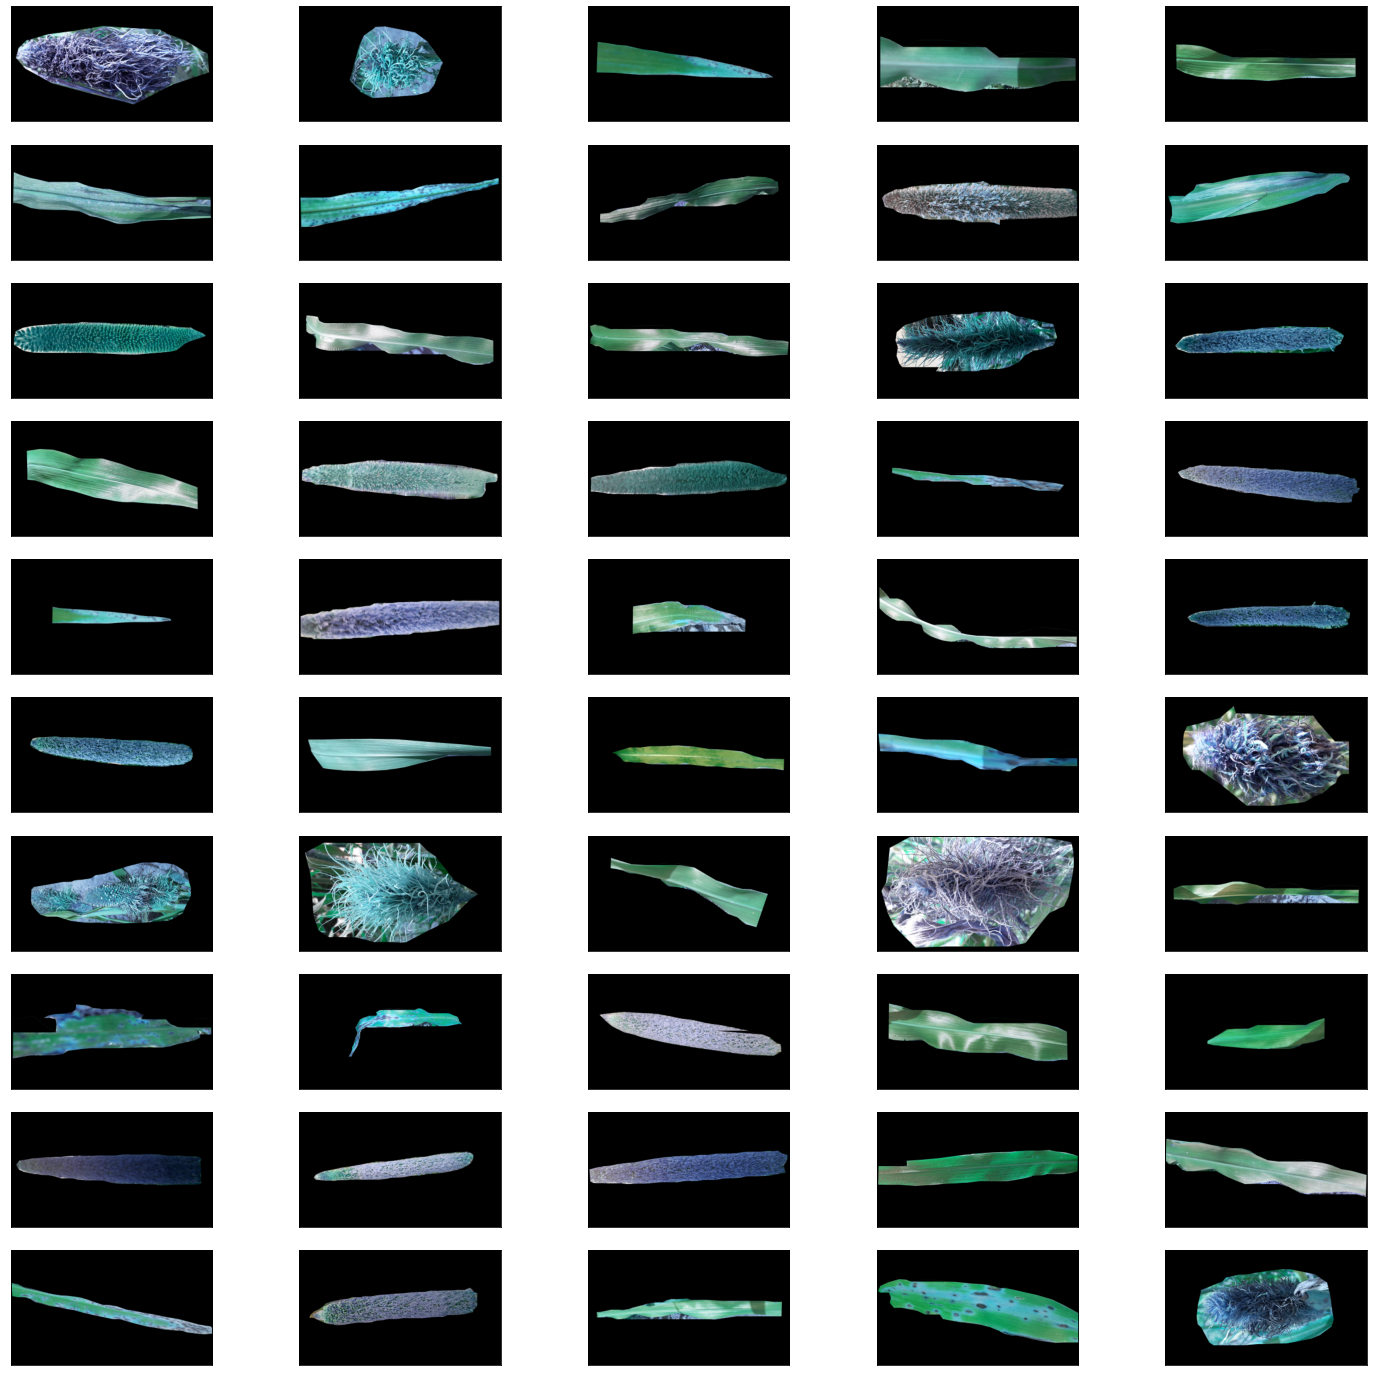

In [ ]:
fig, axs = plt.subplots(nrows=10, ncols=5,figsize=(25,25),
                        subplot_kw={'xticks': [], 'yticks': []})

axs = axs.flat

start = 350
end = 400

for j,img in enumerate(train_x[start:end]):
    axs[j].imshow(img)

In [ ]:
name_dict = {
 'b': 'Black',
 'w': 'White',
 'o': 'Original',
 'a': 'Augmented',
 'A': 'All',
 'L': 'Leaf',
 'E': 'Ear'
}

(a1,a2,a3,a4,a5,a6)=('b','A','a','3','y','2')

model_name = f'./new_models/model-{name_dict[a1]}-{name_dict[a2]}-{name_dict[a3]}-{a4}-{a5}-{a6}'
model = load_model(model_name)

print(model.summary())

last_conv_layer_name = "conv2d_9"

classifier_layer_names = [
    "flatten_3",
    "dense_3",
]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 198, 348, 4)       112       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 66, 116, 4)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 66, 116, 4)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 114, 16)       592       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 38, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 21, 38, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 19, 36, 1)        

In [ ]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        print('pred in function is ', top_pred_index)
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    print('pooled grads is ', pooled_grads)
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # print('heatmap is ', heatmap)
    print('max in heatmap is ',np.max(heatmap))
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap))
    return heatmap

pred in function is  tf.Tensor(1, shape=(), dtype=int64)
pooled grads is  [3.2245826e-08]
max in heatmap is  5.2245746e-08


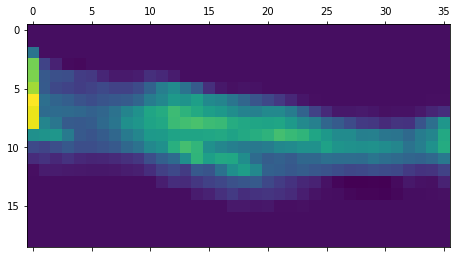

In [ ]:
idx=355

img_array = np.expand_dims(train_x[idx],axis=0)

heatmap = make_gradcam_heatmap(
  img_array, model, last_conv_layer_name, classifier_layer_names
)
plt.matshow(heatmap)
plt.show()

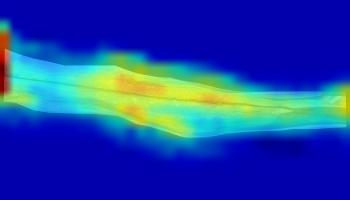

In [ ]:
# We rescale heatmap to a range 0-255
img = img_array[0]

heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.01 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
# save_path = "elephant_cam.jpg"
# superimposed_img.save(save_path)
save_path = "lh_cam.jpg"
superimposed_img.save(save_path)
plt.imsave('lh-orig.jpg',img)

# Display Grad CAM
display(Image(save_path))